In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
import sys
sys.path.append('../')
from utils import visualize_data_sample
from sklearn.utils import shuffle
from keras.api.models import Model
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout, ReLU
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy, mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
x_data = np.load('../datasets/tp4/pipeline_images.npy')
y_data = np.load('../datasets/tp4/pipeline_predections.npy')

In [3]:
print(f'x_data shape : {x_data.shape}')
print(f'y_data shape : {y_data.shape}')

x_data shape : (1112, 228, 308, 3)
y_data shape : (1112, 4)


In [4]:
def preprocess_input(x_data):
    gray_images = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in x_data])
    gray_images = gray_images.astype('float32') / 255.0
    gray_images = np.expand_dims(gray_images, -1)
    
    return gray_images

In [5]:
def preprocess_output(y_data):
    y_data = y_data[:, 0:2]
    y_data[:, 0] = np.abs(y_data[:, 0])
    y_data[:, 0] = np.clip(y_data[:, 0], 0, 5)
    y_data[:, 1] = (y_data[:, 1] >= 0).astype(int)
    return y_data

In [6]:
x_data = preprocess_input(x_data)
y_data = preprocess_output(y_data)

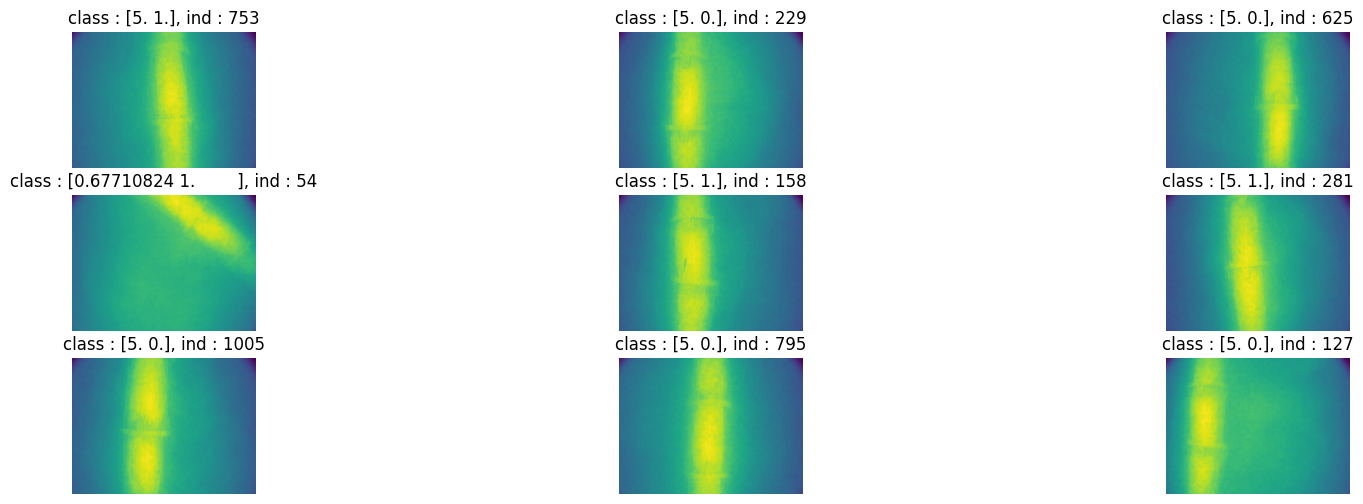

In [7]:
visualize_data_sample(x=x_data, y=y_data, random=True)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, shuffle=True)

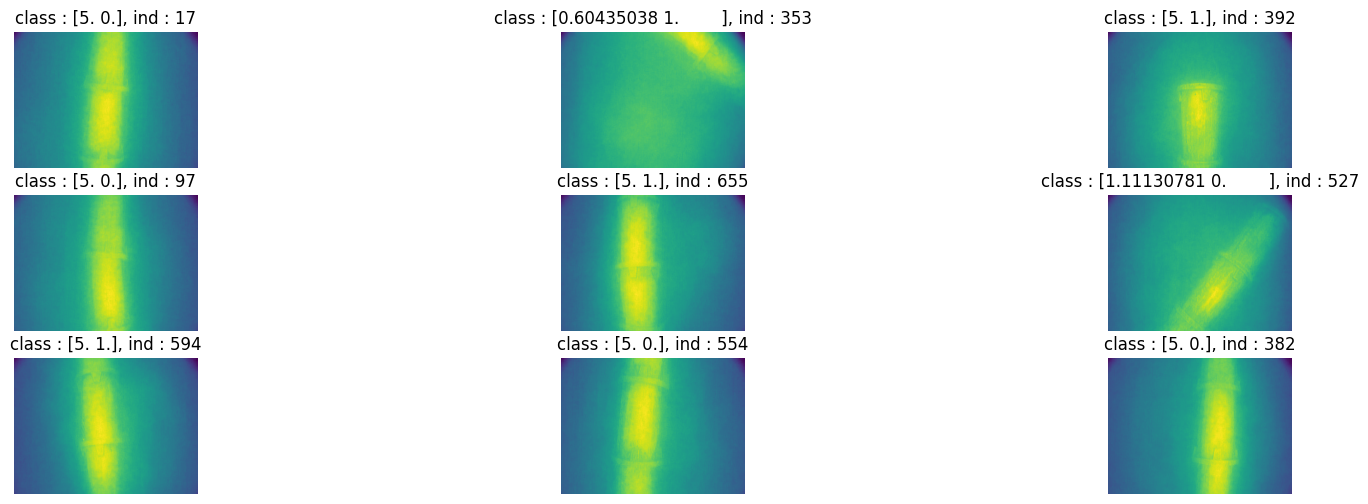

In [10]:
visualize_data_sample(x_train, y_train, random=True)

In [11]:
def print_angle_value(tan):
    print(f'rad value : {math.atan(tan)}')
    print(f'deg value : {math.degrees(math.atan(tan))}')

In [12]:
input = Input((228, 308, 1))

x = Conv2D(filters=16, kernel_size=3, strides=1)(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)


x = Conv2D(filters=8, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(8)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


classification = Dense(1, activation='sigmoid', name='classification')(x)

regression = Dense(1, name='regression')(x)


model = Model(inputs=input, outputs=[classification, regression])

In [14]:
model.summary()
opt = Adam(learning_rate=0.0005)
model.compile(
    optimizer=opt,
    loss={'classification': 'binary_crossentropy', 'regression': 'mean_squared_error'},
    metrics={'classification': 'accuracy', 'regression': 'mean_absolute_error'}
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 228, 308,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 226, 306,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 226, 306,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 226, 306,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 113, 153,  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 76, 8) │      1,160 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 76, 8) │         32 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 76, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 38, 8) │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8512)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │     68,104 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8)         │         32 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 8)         │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │          9 │ leaky_re_lu[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression (Dense)  │ (None, 1)         │          9 │ leaky_re_lu[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,570 (271.76 KB)

 Trainable params: 69,506 (271.51 KB)

 Non-trainable params: 64 (256.00 B)

In [19]:
history = model.fit(
    x=x_train,
    y=[y_train[:, 1].reshape((-1,1)), y_train[:, 0].reshape((-1,1))],
    batch_size=16, 
    epochs=15
)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - classification_accuracy: 0.7217 - classification_loss: 0.6014 - loss: 10.5841 - regression_loss: 9.9835 - regression_mean_absolute_error: 3.0973
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - classification_accuracy: 0.7250 - classification_loss: 0.5862 - loss: 9.6268 - regression_loss: 9.0402 - regression_mean_absolute_error: 2.9439
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - classification_accuracy: 0.7374 - classification_loss: 0.5847 - loss: 8.2556 - regression_loss: 7.6709 - regression_mean_absolute_error: 2.6882
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - classification_accuracy: 0.7245 - classification_loss: 0.5712 - loss: 7.5659 - regression_loss: 6.9952 - regression_mean_absolute_error: 2.5818
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - classification_accuracy: 0.7114 - classification_loss: 0.5698 - loss: 6.4343 - regression_loss: 5.8644 - regression_mean_absolute_error: 2.3607
Epoch 6/1